Camvid Detection

In [ ]:
!kaggle datasets download -d carlolepelaars/camvid

Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid
License(s): CC-BY-NC-SA-4.0
100% 575M/575M [00:16<00:00, 28.7MB/s]
100% 575M/575M [00:16<00:00, 35.5MB/s]


In [ ]:
!unzip "/content/camvid.zip"

Archive:  /content/camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Conv2DTranspose,concatenate,Input,Dropout
from tensorflow.keras.utils import to_categorical

**Load Data**

In [ ]:
train_image_path ="/content/CamVid/train/"
train_label_path = "/content/CamVid/train_labels/"

test_image_path = "/content/CamVid/test/"
test_label_path= "/content/CamVid/test_labels/"

val_image_path ="/content/CamVid/val/"
val_mask_path= "/content/CamVid/val_labels/"

In [ ]:
df = pd.read_csv('/content/CamVid/class_dict.csv')
df.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


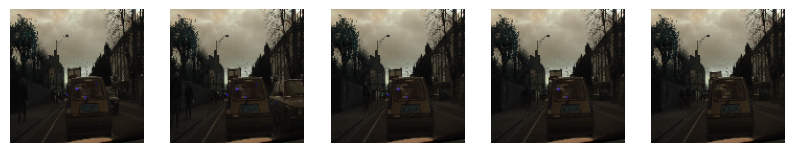

In [ ]:
train_img =[]

train_img_dir= sorted(os.listdir(train_image_path))
test_img_dir = sorted(os.listdir(test_image_path))


for name in train_img_dir:
  image = cv2.imread(os.path.join(train_image_path, name))
  image = cv2.resize(image , (128,128))
  train_img.append(image)


for test_name in test_img_dir:
    image=cv2.imread(os.path.join(test_image_path,test_name))
    image=cv2.resize(image,(128,128))
    train_img.append(image)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_img[i])
    plt.axis('off')


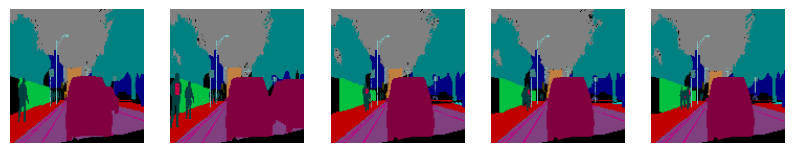

In [ ]:
train_label =[]

train_label_dir= sorted(os.listdir(train_label_path))
test_label_dir = sorted(os.listdir(test_label_path))


for name in train_label_dir:
  label = cv2.imread(os.path.join(train_label_path, name))
  label = cv2.resize(label , (128,128))
  train_label.append(label)


for test_name in test_label_dir:
    label=cv2.imread(os.path.join(test_label_path,test_name))
    label=cv2.resize(label,(128,128))
    train_label.append(label)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_label[i])
    plt.axis('off')


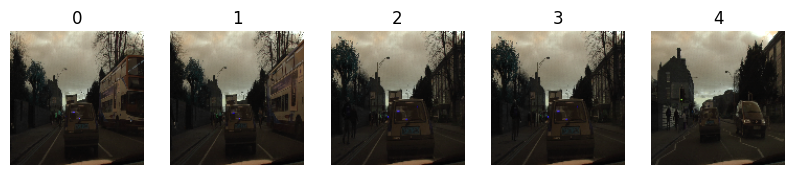

In [ ]:
val_img=[]
val_img_dir=sorted(os.listdir(val_image_path))

for name in val_img_dir:
    image=cv2.imread(os.path.join(val_image_path,name))
    image=cv2.resize(image,(128,128))
    val_img.append(image)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(val_img[i])
    plt.title(i)
    plt.axis('off')

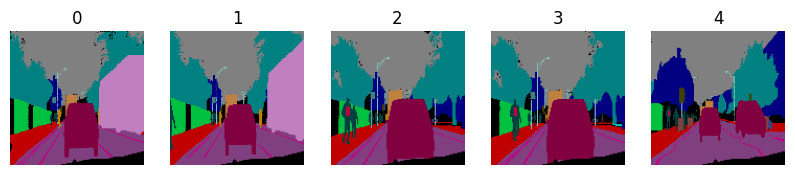

In [ ]:
val_label=[]
val_label_dir=sorted(os.listdir(val_mask_path))

for name in val_label_dir:
    label=cv2.imread(os.path.join(val_mask_path,name))
    label=cv2.resize(label,(128,128))
    val_label.append(label)

plt.figure(figsize=(10,10))
for i in range (5):
    plt.subplot(1,5,i+1)
    plt.imshow(val_label[i])
    plt.title(i)
    plt.axis('off')

In [ ]:
train_img= np.array(train_img)/255
train_label = np.array(train_label)/255

val_img = np.array(val_img)/255
val_label = np.array(val_label) /255

In [ ]:
print(f'Train Shape :\n{train_img.shape}\n{train_label.shape}\n\nVal Shape:  \n{val_img.shape}\n{val_label.shape}')


Train Shape :
(601, 128, 128, 3)
(601, 128, 128, 3)

Val Shape:  
(100, 128, 128, 3)
(100, 128, 128, 3)


In [ ]:
train_label=to_categorical(np.argmax(train_label,axis=-1),num_classes=32)
val_label=to_categorical(np.argmax(val_label,axis=-1),num_classes=32)

In [ ]:
inputs=Input((128,128,3))

c1 = Conv2D(64,(3,3),padding='same',activation='relu')(inputs)
b1 = BatchNormalization()(c1)
c1 = Conv2D(64,(3,3),padding='same',activation='relu')(b1)
b1 = BatchNormalization()(c1)
p1 = MaxPooling2D()(b1)
d1 = Dropout(0.2)(p1)

c2 = Conv2D(128,(3,3),padding='same',activation='relu')(d1)
b2 = BatchNormalization()(c2)
c2 = Conv2D(128,(3,3),padding='same',activation='relu')((b2))
b2 = BatchNormalization()(c2)
p2 = MaxPooling2D()(b2)
d2 = Dropout(0.3)(p2)

c3 = Conv2D(256,(3,3),padding='same',activation='relu')(d2)
b3 = BatchNormalization()(c3)
c3 = Conv2D(256,(3,3),padding='same',activation='relu')(b3)
b3 = BatchNormalization()(c3)
p3 = MaxPooling2D()(b3)
d3 = Dropout(0.4)(p3)

c4 = Conv2D(512,(3,3),padding='same',activation='relu')(d3)
b4 = BatchNormalization()(c4)
c4 = Conv2D(512,(3,3),padding='same',activation='relu')(b4)
b4 = BatchNormalization()(c4)
p4 = MaxPooling2D()(b4)



c5 = Conv2D(1024,(3,3),padding='same',activation='relu')(p4)
b5 = BatchNormalization()(c5)
c5 = Conv2D(1024,(3,3),padding='same',activation='relu')(b5)
b5 = BatchNormalization()(c5)



u6 = Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation='relu')(b5)
u6 = concatenate([u6,c4])
c6 = Conv2D(512,(3,3),padding='same',activation='relu')(u6)
b6 = BatchNormalization()(c6)
c6 = Conv2D(512,(3,3),padding='same',activation='relu')(b6)
b6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same',activation='relu')(c6)
u7 = concatenate([u7,b3])
c7 = Conv2D(256,(3,3),padding='same',activation='relu')(u7)
b7 = BatchNormalization()(c7)
c7 = Conv2D(256,(3,3),padding='same',activation='relu')(b7)
b7 = BatchNormalization()(c7)
d7 = Dropout(0.4)(b7)

u8 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same',activation='relu')(d7)
u8 = concatenate([u8,b2])
c8 = Conv2D(128,(3,3),padding='same',activation='relu')(u8)
b8 = BatchNormalization()(c8)
c8 = Conv2D(128,(3,3),padding='same',activation='relu')(b8)
b8 = BatchNormalization()(c8)
d8 = Dropout(0.3)(b8)

u9 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same',activation='relu')(d8)
u9 = concatenate([u9,b1])
c9 = Conv2D(64,(3,3),padding='same',activation='relu')(u9)
b9 = BatchNormalization()(c9)
c9 = Conv2D(64,(3,3),padding='same',activation='relu')(b9)
b9 = BatchNormalization()(c9)
d9 = Dropout(0.2)(b9)

outputs=Conv2D(32,(1,1),padding='same',activation='softmax')(d9)

model=tf.keras.Model(inputs , outputs,name='U-Net')
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_4… │
├──────────────────────

 Total params: 31,055,264 (118.47 MB)

 Trainable params: 31,044,512 (118.43 MB)

 Non-trainable params: 10,752 (42.00 KB)

In [ ]:
decay=tf.keras.optimizers.schedules.ExponentialDecay(0.0001,
                                                     decay_steps=1500,
                                                     decay_rate=0.5)
def scheduler(lr,epochs):
    if epochs <40:
        return lr
    elif epochs >=40:
        return lr * 0.5

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=tf.keras.optimizers.Adam(decay),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,train_label,
                    validation_data=(val_img,val_label),
                    epochs=25,
                    batch_size=16,
                    )

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 634ms/step - accuracy: 0.9266 - loss: 0.2691 - val_accuracy: 0.9086 - val_loss: 0.4511
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.9311 - loss: 0.2396 - val_accuracy: 0.9080 - val_loss: 0.3865
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9321 - loss: 0.2306 - val_accuracy: 0.9043 - val_loss: 0.4135
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9339 - loss: 0.2184 - val_accuracy: 0.9131 - val_loss: 0.3605
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9334 - loss: 0.2148 - val_accuracy: 0.9091 - val_loss: 0.3812
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.9336 - loss: 0.2144 - val_accuracy: 0.9101 - val_loss: 0.3937
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9381 - loss: 0.1931 - val_accuracy: 0.9167 - val_loss: 0.3349
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9396 - loss: 0.1843 - val_accu